In [1]:
!nvidia-smi

Wed Mar 29 16:39:33 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "nifti"

In [4]:
#pip install openpyxl

patient_data = pd.read_excel("patient_data.xlsx", usecols="A,B")

In [5]:
"""import SimpleITK as sitk

image_dir = "result"

def pngs2Nifti(patient_id, image_type, output_path):
    file_names = glob.glob(os.path.join(image_dir, patient_id, image_type, "*.png"))
    if file_names:
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(file_names)
        vol = reader.Execute()
        sitk.WriteImage(vol, os.path.join(output_path, patient_id + ".nii.gz"))"""

'import SimpleITK as sitk\n\nimage_dir = "result"\n\ndef pngs2Nifti(patient_id, image_type, output_path):\n    file_names = glob.glob(os.path.join(image_dir, patient_id, image_type, "*.png"))\n    if file_names:\n        reader = sitk.ImageSeriesReader()\n        reader.SetFileNames(file_names)\n        vol = reader.Execute()\n        sitk.WriteImage(vol, os.path.join(output_path, patient_id + ".nii.gz"))'

In [6]:
"""#!find . -name ".DS_Store" -exec rm {} \;

patients = sorted(os.listdir("result"))
for patient in patients:
    pngs2Nifti(patient, "AP_crop", "nifti/AP")
    pngs2Nifti(patient, "HBP_crop", "nifti/HBP")"""

'#!find . -name ".DS_Store" -exec rm {} \\;\n\npatients = sorted(os.listdir("result"))\nfor patient in patients:\n    pngs2Nifti(patient, "AP_crop", "nifti/AP")\n    pngs2Nifti(patient, "HBP_crop", "nifti/HBP")'

In [10]:
import random

train_images = sorted(glob.glob(os.path.join(data_dir, "HBP", "*.nii.gz")))
train_labels = torch.nn.functional.one_hot(torch.as_tensor(patient_data["MVI"])).float()
data_list = list(zip(train_images, train_labels))

set_determinism(seed=0)

In [11]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    AddChanneld,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandAffined,
    SpatialPadd,
    EnsureTyped,
)

In [12]:
# ScaleIntensityRanged min/max differ by organs
# for liver, min = 30 + 150/2 = 105, max = 30 - 150/2 = -45
# see more info here https://radiopaedia.org/articles/windowing-ct

from monai.transforms import Compose

train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-45, a_max=105,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        RandAffined(
            keys=["image"],
            mode=("bilinear"),
            prob=1.0, spatial_size=(96, 96, 16),
            rotate_range=(0, 0, 0),
            scale_range=(0, 0, 0)),
        SpatialPadd(keys=["image"], spatial_size=(96, 96, 96)),
        EnsureTyped(keys=["image"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-45, a_max=105,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=(96, 96, 96)),
        EnsureTyped(keys=["image"]),
    ]
)

In [21]:
from monai.data import CacheDataset, DataLoader

def shuffle_data():
    random.shuffle(data_list)
    data_dicts = [{"image": image, "label": label} for image, label in data_list]
    train_files, val_files = data_dicts[:200], data_dicts[200:]
    train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4, progress=True)
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=10)
    val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)
    return train_ds, train_loader, val_ds, val_loader

In [22]:
from monai.networks.nets import DenseNet121

device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=3,
    in_channels=1,
    out_channels=2
).to(device)

In [23]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
max_epochs = 100
val_interval = 2
save_interval = 10
best_score = -1
best_score_epoch = -1
epoch_loss_values = []
metric_values = []
model_name = 'Densenet'

In [24]:
%%time

import time

for epoch in range(max_epochs):
    train_ds, train_loader, val_ds, val_loader = shuffle_data()
    tic_epoch = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 5 ==0:
            print(f"\nepoch {epoch + 1}/{max_epochs} steps {step}/{len(train_ds) // train_loader.batch_size}, |train-loss: {loss.item():.4f}", end='')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    toc_epoch = time.time()
    dur_epoch = toc_epoch - tic_epoch
    print(f" |avg-loss: {epoch_loss:.4f} dur {dur_epoch:.1f}s ", end='')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_count = 0
        val_correct = 0.0
        
        with torch.no_grad():
            for val_data in val_loader:
                inputs, labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                outputs = model(inputs)
                val_result = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
                val_count += len(val_result)
                val_correct += val_result.sum().item()
            
            val_score = val_correct / val_count
            metric_values.append(val_score)
            print(f"|val-acc: {val_score:.4f} |old-best: {best_score:.4f} " , end="")
            
            if val_score > best_score:
                best_score = val_score
                best_score_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_best.pth".format(model_name)))
                torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_best.pth".format(model_name)))
                print("|best model saved", end="")
    
    if (epoch+1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_{:04d}.pth".format(model_name, epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_{:04d}.pth".format(model_name, epoch+1)))
        print("|{}ep model saved".format(epoch+1), end='')
                            
print(f"\ntrain completed, best_metric: {best_score:.4f} at epoch: {best_score_epoch} for {max_epochs} epoches")

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 132.15it/s]



epoch 1/100 steps 5/50, |train-loss: 0.6752
epoch 1/100 steps 10/50, |train-loss: 0.7464
epoch 1/100 steps 15/50, |train-loss: 0.6480
epoch 1/100 steps 20/50, |train-loss: 0.7189
epoch 1/100 steps 25/50, |train-loss: 0.7756
epoch 1/100 steps 30/50, |train-loss: 0.6679
epoch 1/100 steps 35/50, |train-loss: 0.6812
epoch 1/100 steps 40/50, |train-loss: 0.7644
epoch 1/100 steps 45/50, |train-loss: 0.6891
epoch 1/100 steps 50/50, |train-loss: 0.7230 |avg-loss: 0.7041 dur 78.7s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 124.23it/s]



epoch 2/100 steps 5/50, |train-loss: 0.6383
epoch 2/100 steps 10/50, |train-loss: 0.5897
epoch 2/100 steps 15/50, |train-loss: 0.7219
epoch 2/100 steps 20/50, |train-loss: 0.6088
epoch 2/100 steps 25/50, |train-loss: 0.6483
epoch 2/100 steps 30/50, |train-loss: 0.7392
epoch 2/100 steps 35/50, |train-loss: 0.7750
epoch 2/100 steps 40/50, |train-loss: 0.6894
epoch 2/100 steps 45/50, |train-loss: 0.7425
epoch 2/100 steps 50/50, |train-loss: 0.6742 |avg-loss: 0.6968 dur 79.0s |val-acc: 0.4348 |old-best: -1.0000 |best model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 129.69it/s]



epoch 3/100 steps 5/50, |train-loss: 0.8394
epoch 3/100 steps 10/50, |train-loss: 0.7075
epoch 3/100 steps 15/50, |train-loss: 0.6595
epoch 3/100 steps 20/50, |train-loss: 0.6794
epoch 3/100 steps 25/50, |train-loss: 0.7317
epoch 3/100 steps 30/50, |train-loss: 0.6110
epoch 3/100 steps 35/50, |train-loss: 0.7605
epoch 3/100 steps 40/50, |train-loss: 0.7214
epoch 3/100 steps 45/50, |train-loss: 0.6872
epoch 3/100 steps 50/50, |train-loss: 0.7683 |avg-loss: 0.7027 dur 79.8s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 122.29it/s]



epoch 4/100 steps 5/50, |train-loss: 0.7370
epoch 4/100 steps 10/50, |train-loss: 0.7172
epoch 4/100 steps 15/50, |train-loss: 0.5990
epoch 4/100 steps 20/50, |train-loss: 0.7345
epoch 4/100 steps 25/50, |train-loss: 0.7521
epoch 4/100 steps 30/50, |train-loss: 0.6974
epoch 4/100 steps 35/50, |train-loss: 0.7076
epoch 4/100 steps 40/50, |train-loss: 0.6259
epoch 4/100 steps 45/50, |train-loss: 0.6598
epoch 4/100 steps 50/50, |train-loss: 0.6692 |avg-loss: 0.6861 dur 79.6s |val-acc: 0.4348 |old-best: 0.4348 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 127.34it/s]



epoch 5/100 steps 5/50, |train-loss: 0.8058
epoch 5/100 steps 10/50, |train-loss: 0.6714
epoch 5/100 steps 15/50, |train-loss: 0.6712
epoch 5/100 steps 20/50, |train-loss: 0.7602
epoch 5/100 steps 25/50, |train-loss: 0.6485
epoch 5/100 steps 30/50, |train-loss: 0.7757
epoch 5/100 steps 35/50, |train-loss: 0.6930
epoch 5/100 steps 40/50, |train-loss: 0.6819
epoch 5/100 steps 45/50, |train-loss: 0.6856
epoch 5/100 steps 50/50, |train-loss: 0.7034 |avg-loss: 0.7034 dur 80.1s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 133.05it/s]



epoch 6/100 steps 5/50, |train-loss: 0.6918
epoch 6/100 steps 10/50, |train-loss: 0.6791
epoch 6/100 steps 15/50, |train-loss: 0.5424
epoch 6/100 steps 20/50, |train-loss: 0.7434
epoch 6/100 steps 25/50, |train-loss: 0.7724
epoch 6/100 steps 30/50, |train-loss: 0.6872
epoch 6/100 steps 35/50, |train-loss: 0.6602
epoch 6/100 steps 40/50, |train-loss: 0.5843
epoch 6/100 steps 45/50, |train-loss: 0.7836
epoch 6/100 steps 50/50, |train-loss: 0.7013 |avg-loss: 0.6979 dur 79.9s |val-acc: 0.5435 |old-best: 0.4348 |best model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 129.55it/s]



epoch 7/100 steps 5/50, |train-loss: 0.8339
epoch 7/100 steps 10/50, |train-loss: 0.6285
epoch 7/100 steps 15/50, |train-loss: 0.6825
epoch 7/100 steps 20/50, |train-loss: 0.7503
epoch 7/100 steps 25/50, |train-loss: 0.7113
epoch 7/100 steps 30/50, |train-loss: 0.6867
epoch 7/100 steps 35/50, |train-loss: 0.6519
epoch 7/100 steps 40/50, |train-loss: 0.7005
epoch 7/100 steps 45/50, |train-loss: 0.6936
epoch 7/100 steps 50/50, |train-loss: 0.8116 |avg-loss: 0.6915 dur 79.5s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 132.21it/s]



epoch 8/100 steps 5/50, |train-loss: 0.6434
epoch 8/100 steps 10/50, |train-loss: 0.5654
epoch 8/100 steps 15/50, |train-loss: 0.5915
epoch 8/100 steps 20/50, |train-loss: 0.7702
epoch 8/100 steps 25/50, |train-loss: 0.6578
epoch 8/100 steps 30/50, |train-loss: 0.6902
epoch 8/100 steps 35/50, |train-loss: 0.6141
epoch 8/100 steps 40/50, |train-loss: 0.7199
epoch 8/100 steps 45/50, |train-loss: 0.7392
epoch 8/100 steps 50/50, |train-loss: 0.6775 |avg-loss: 0.7046 dur 78.1s |val-acc: 0.5652 |old-best: 0.5435 |best model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 131.52it/s]



epoch 9/100 steps 5/50, |train-loss: 0.7246
epoch 9/100 steps 10/50, |train-loss: 0.6923
epoch 9/100 steps 15/50, |train-loss: 0.6451
epoch 9/100 steps 20/50, |train-loss: 0.7061
epoch 9/100 steps 25/50, |train-loss: 0.6721
epoch 9/100 steps 30/50, |train-loss: 0.6432
epoch 9/100 steps 35/50, |train-loss: 0.7372
epoch 9/100 steps 40/50, |train-loss: 0.6446
epoch 9/100 steps 45/50, |train-loss: 0.6653
epoch 9/100 steps 50/50, |train-loss: 0.6162 |avg-loss: 0.6814 dur 78.8s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 130.04it/s]



epoch 10/100 steps 5/50, |train-loss: 0.7024
epoch 10/100 steps 10/50, |train-loss: 0.7882
epoch 10/100 steps 15/50, |train-loss: 0.6857
epoch 10/100 steps 20/50, |train-loss: 0.7239
epoch 10/100 steps 25/50, |train-loss: 0.6131
epoch 10/100 steps 30/50, |train-loss: 0.7005
epoch 10/100 steps 35/50, |train-loss: 0.7628
epoch 10/100 steps 40/50, |train-loss: 0.7004
epoch 10/100 steps 45/50, |train-loss: 0.5785
epoch 10/100 steps 50/50, |train-loss: 0.5947 |avg-loss: 0.6722 dur 79.8s |val-acc: 0.5217 |old-best: 0.5652 |10ep model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 123.54it/s]



epoch 11/100 steps 5/50, |train-loss: 0.6879
epoch 11/100 steps 10/50, |train-loss: 0.7104
epoch 11/100 steps 15/50, |train-loss: 0.6198
epoch 11/100 steps 20/50, |train-loss: 0.8025
epoch 11/100 steps 25/50, |train-loss: 0.7566
epoch 11/100 steps 30/50, |train-loss: 0.6380
epoch 11/100 steps 35/50, |train-loss: 0.7968
epoch 11/100 steps 40/50, |train-loss: 0.6604
epoch 11/100 steps 45/50, |train-loss: 0.5458
epoch 11/100 steps 50/50, |train-loss: 0.6450 |avg-loss: 0.6752 dur 80.0s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 107.71it/s]



epoch 12/100 steps 5/50, |train-loss: 0.3634
epoch 12/100 steps 10/50, |train-loss: 0.6801
epoch 12/100 steps 15/50, |train-loss: 0.7180
epoch 12/100 steps 20/50, |train-loss: 0.4818
epoch 12/100 steps 25/50, |train-loss: 0.9627
epoch 12/100 steps 30/50, |train-loss: 0.7201
epoch 12/100 steps 35/50, |train-loss: 0.5390
epoch 12/100 steps 40/50, |train-loss: 0.7241
epoch 12/100 steps 45/50, |train-loss: 0.4100
epoch 12/100 steps 50/50, |train-loss: 0.7665 |avg-loss: 0.6596 dur 80.3s |val-acc: 0.5435 |old-best: 0.5652 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 120.96it/s]



epoch 13/100 steps 5/50, |train-loss: 0.5745
epoch 13/100 steps 10/50, |train-loss: 0.7028
epoch 13/100 steps 15/50, |train-loss: 0.6625
epoch 13/100 steps 20/50, |train-loss: 0.5921
epoch 13/100 steps 25/50, |train-loss: 0.6455
epoch 13/100 steps 30/50, |train-loss: 0.7359
epoch 13/100 steps 35/50, |train-loss: 0.6130
epoch 13/100 steps 40/50, |train-loss: 0.5097
epoch 13/100 steps 45/50, |train-loss: 0.5604
epoch 13/100 steps 50/50, |train-loss: 0.7778 |avg-loss: 0.6489 dur 79.8s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 126.50it/s]



epoch 14/100 steps 5/50, |train-loss: 0.7261
epoch 14/100 steps 10/50, |train-loss: 0.6828
epoch 14/100 steps 15/50, |train-loss: 0.6470
epoch 14/100 steps 20/50, |train-loss: 0.6558
epoch 14/100 steps 25/50, |train-loss: 0.8116
epoch 14/100 steps 30/50, |train-loss: 0.7679
epoch 14/100 steps 35/50, |train-loss: 0.7440
epoch 14/100 steps 40/50, |train-loss: 0.6473
epoch 14/100 steps 45/50, |train-loss: 0.6286
epoch 14/100 steps 50/50, |train-loss: 0.4846 |avg-loss: 0.6544 dur 79.1s |val-acc: 0.6304 |old-best: 0.5652 |best model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 128.55it/s]



epoch 15/100 steps 5/50, |train-loss: 0.7029
epoch 15/100 steps 10/50, |train-loss: 0.5353
epoch 15/100 steps 15/50, |train-loss: 0.7995
epoch 15/100 steps 20/50, |train-loss: 0.4521
epoch 15/100 steps 25/50, |train-loss: 0.5840
epoch 15/100 steps 30/50, |train-loss: 0.7613
epoch 15/100 steps 35/50, |train-loss: 0.7757
epoch 15/100 steps 40/50, |train-loss: 0.6768
epoch 15/100 steps 45/50, |train-loss: 0.6288
epoch 15/100 steps 50/50, |train-loss: 0.7956 |avg-loss: 0.6634 dur 79.4s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 130.91it/s]



epoch 16/100 steps 5/50, |train-loss: 0.7119
epoch 16/100 steps 10/50, |train-loss: 0.7920
epoch 16/100 steps 15/50, |train-loss: 0.4743
epoch 16/100 steps 20/50, |train-loss: 0.6185
epoch 16/100 steps 25/50, |train-loss: 0.7521
epoch 16/100 steps 30/50, |train-loss: 0.6940
epoch 16/100 steps 35/50, |train-loss: 0.7960
epoch 16/100 steps 40/50, |train-loss: 0.4439
epoch 16/100 steps 45/50, |train-loss: 0.4638
epoch 16/100 steps 50/50, |train-loss: 0.8255 |avg-loss: 0.6456 dur 80.4s |val-acc: 0.5000 |old-best: 0.6304 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 134.27it/s]



epoch 17/100 steps 5/50, |train-loss: 0.5253
epoch 17/100 steps 10/50, |train-loss: 0.2700
epoch 17/100 steps 15/50, |train-loss: 0.4174
epoch 17/100 steps 20/50, |train-loss: 0.6309
epoch 17/100 steps 25/50, |train-loss: 0.5410
epoch 17/100 steps 30/50, |train-loss: 0.4775
epoch 17/100 steps 35/50, |train-loss: 0.9766
epoch 17/100 steps 40/50, |train-loss: 0.8393
epoch 17/100 steps 45/50, |train-loss: 0.5474
epoch 17/100 steps 50/50, |train-loss: 0.7364 |avg-loss: 0.5787 dur 79.7s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 136.05it/s]



epoch 18/100 steps 5/50, |train-loss: 0.7465
epoch 18/100 steps 10/50, |train-loss: 0.4985
epoch 18/100 steps 15/50, |train-loss: 0.4321
epoch 18/100 steps 20/50, |train-loss: 0.5668
epoch 18/100 steps 25/50, |train-loss: 1.3476
epoch 18/100 steps 30/50, |train-loss: 0.8070
epoch 18/100 steps 35/50, |train-loss: 0.5200
epoch 18/100 steps 40/50, |train-loss: 0.5702
epoch 18/100 steps 45/50, |train-loss: 0.6831
epoch 18/100 steps 50/50, |train-loss: 0.8379 |avg-loss: 0.6284 dur 79.9s |val-acc: 0.5217 |old-best: 0.6304 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 134.78it/s]



epoch 19/100 steps 5/50, |train-loss: 0.8005
epoch 19/100 steps 10/50, |train-loss: 0.5145
epoch 19/100 steps 15/50, |train-loss: 0.4462
epoch 19/100 steps 20/50, |train-loss: 0.5213
epoch 19/100 steps 25/50, |train-loss: 0.7654
epoch 19/100 steps 30/50, |train-loss: 0.6643
epoch 19/100 steps 35/50, |train-loss: 0.4569
epoch 19/100 steps 40/50, |train-loss: 0.5676
epoch 19/100 steps 45/50, |train-loss: 0.7276
epoch 19/100 steps 50/50, |train-loss: 0.6305 |avg-loss: 0.6564 dur 79.9s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 116.35it/s]



epoch 20/100 steps 5/50, |train-loss: 0.6661
epoch 20/100 steps 10/50, |train-loss: 0.6345
epoch 20/100 steps 15/50, |train-loss: 0.7114
epoch 20/100 steps 20/50, |train-loss: 0.6955
epoch 20/100 steps 25/50, |train-loss: 0.8071
epoch 20/100 steps 30/50, |train-loss: 0.4016
epoch 20/100 steps 35/50, |train-loss: 0.4801
epoch 20/100 steps 40/50, |train-loss: 0.6775
epoch 20/100 steps 45/50, |train-loss: 0.8023
epoch 20/100 steps 50/50, |train-loss: 0.5551 |avg-loss: 0.6014 dur 79.4s |val-acc: 0.5000 |old-best: 0.6304 |20ep model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 130.35it/s]



epoch 21/100 steps 5/50, |train-loss: 1.1171
epoch 21/100 steps 10/50, |train-loss: 0.4496
epoch 21/100 steps 15/50, |train-loss: 0.4566
epoch 21/100 steps 20/50, |train-loss: 0.3478
epoch 21/100 steps 25/50, |train-loss: 0.7654
epoch 21/100 steps 30/50, |train-loss: 0.6494
epoch 21/100 steps 35/50, |train-loss: 0.9995
epoch 21/100 steps 40/50, |train-loss: 0.3565
epoch 21/100 steps 45/50, |train-loss: 0.5661
epoch 21/100 steps 50/50, |train-loss: 0.8137 |avg-loss: 0.5992 dur 79.1s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 121.91it/s]



epoch 22/100 steps 5/50, |train-loss: 0.6573
epoch 22/100 steps 10/50, |train-loss: 0.3600
epoch 22/100 steps 15/50, |train-loss: 0.7260
epoch 22/100 steps 20/50, |train-loss: 0.5312
epoch 22/100 steps 25/50, |train-loss: 0.4306
epoch 22/100 steps 30/50, |train-loss: 0.4860
epoch 22/100 steps 35/50, |train-loss: 0.3999
epoch 22/100 steps 40/50, |train-loss: 0.6453
epoch 22/100 steps 45/50, |train-loss: 0.5055
epoch 22/100 steps 50/50, |train-loss: 0.4910 |avg-loss: 0.5892 dur 78.7s |val-acc: 0.5870 |old-best: 0.6304 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 108.25it/s]



epoch 23/100 steps 5/50, |train-loss: 0.5329
epoch 23/100 steps 10/50, |train-loss: 0.3401
epoch 23/100 steps 15/50, |train-loss: 0.4147
epoch 23/100 steps 20/50, |train-loss: 0.9467
epoch 23/100 steps 25/50, |train-loss: 0.4444
epoch 23/100 steps 30/50, |train-loss: 0.7457
epoch 23/100 steps 35/50, |train-loss: 0.3242
epoch 23/100 steps 40/50, |train-loss: 0.7421
epoch 23/100 steps 45/50, |train-loss: 0.6897
epoch 23/100 steps 50/50, |train-loss: 0.8102 |avg-loss: 0.5664 dur 78.9s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 128.46it/s]



epoch 24/100 steps 5/50, |train-loss: 0.6800
epoch 24/100 steps 10/50, |train-loss: 0.8139
epoch 24/100 steps 15/50, |train-loss: 0.9739
epoch 24/100 steps 20/50, |train-loss: 0.9641
epoch 24/100 steps 25/50, |train-loss: 0.4804
epoch 24/100 steps 30/50, |train-loss: 0.7240
epoch 24/100 steps 35/50, |train-loss: 0.6815
epoch 24/100 steps 40/50, |train-loss: 0.5870
epoch 24/100 steps 45/50, |train-loss: 0.3625
epoch 24/100 steps 50/50, |train-loss: 0.8273 |avg-loss: 0.5574 dur 79.3s |val-acc: 0.4783 |old-best: 0.6304 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 131.78it/s]



epoch 25/100 steps 5/50, |train-loss: 0.7662
epoch 25/100 steps 10/50, |train-loss: 0.4625
epoch 25/100 steps 15/50, |train-loss: 0.7919
epoch 25/100 steps 20/50, |train-loss: 0.5417
epoch 25/100 steps 25/50, |train-loss: 0.3341
epoch 25/100 steps 30/50, |train-loss: 0.6841
epoch 25/100 steps 35/50, |train-loss: 0.6267
epoch 25/100 steps 40/50, |train-loss: 0.6750
epoch 25/100 steps 45/50, |train-loss: 0.9787
epoch 25/100 steps 50/50, |train-loss: 0.9154 |avg-loss: 0.6116 dur 79.8s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 114.21it/s]



epoch 26/100 steps 5/50, |train-loss: 0.6370
epoch 26/100 steps 10/50, |train-loss: 0.9140
epoch 26/100 steps 15/50, |train-loss: 0.4921
epoch 26/100 steps 20/50, |train-loss: 0.7017
epoch 26/100 steps 25/50, |train-loss: 0.5002
epoch 26/100 steps 30/50, |train-loss: 0.3015
epoch 26/100 steps 35/50, |train-loss: 0.4718
epoch 26/100 steps 40/50, |train-loss: 0.3857
epoch 26/100 steps 45/50, |train-loss: 0.3923
epoch 26/100 steps 50/50, |train-loss: 0.3469 |avg-loss: 0.5717 dur 80.8s |val-acc: 0.7826 |old-best: 0.6304 |best model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 112.06it/s]



epoch 27/100 steps 5/50, |train-loss: 0.7176
epoch 27/100 steps 10/50, |train-loss: 0.4173
epoch 27/100 steps 15/50, |train-loss: 0.5462
epoch 27/100 steps 20/50, |train-loss: 0.3666
epoch 27/100 steps 25/50, |train-loss: 0.5173
epoch 27/100 steps 30/50, |train-loss: 0.4312
epoch 27/100 steps 35/50, |train-loss: 0.6248
epoch 27/100 steps 40/50, |train-loss: 0.3113
epoch 27/100 steps 45/50, |train-loss: 0.8167
epoch 27/100 steps 50/50, |train-loss: 0.6918 |avg-loss: 0.4978 dur 80.1s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 127.69it/s]



epoch 28/100 steps 5/50, |train-loss: 0.3974
epoch 28/100 steps 10/50, |train-loss: 0.5488
epoch 28/100 steps 15/50, |train-loss: 0.1849
epoch 28/100 steps 20/50, |train-loss: 0.4921
epoch 28/100 steps 25/50, |train-loss: 0.6794
epoch 28/100 steps 30/50, |train-loss: 0.7096
epoch 28/100 steps 35/50, |train-loss: 0.7760
epoch 28/100 steps 40/50, |train-loss: 0.7867
epoch 28/100 steps 45/50, |train-loss: 0.5754
epoch 28/100 steps 50/50, |train-loss: 0.3560 |avg-loss: 0.5949 dur 80.9s |val-acc: 0.8043 |old-best: 0.7826 |best model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 120.86it/s]



epoch 29/100 steps 5/50, |train-loss: 0.3649
epoch 29/100 steps 10/50, |train-loss: 0.5386
epoch 29/100 steps 15/50, |train-loss: 0.6150
epoch 29/100 steps 20/50, |train-loss: 0.3654
epoch 29/100 steps 25/50, |train-loss: 0.4603
epoch 29/100 steps 30/50, |train-loss: 0.3934
epoch 29/100 steps 35/50, |train-loss: 0.9577
epoch 29/100 steps 40/50, |train-loss: 0.5736
epoch 29/100 steps 45/50, |train-loss: 0.7703
epoch 29/100 steps 50/50, |train-loss: 0.7291 |avg-loss: 0.5415 dur 80.7s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 117.95it/s]



epoch 30/100 steps 5/50, |train-loss: 0.4419
epoch 30/100 steps 10/50, |train-loss: 0.4196
epoch 30/100 steps 15/50, |train-loss: 0.4457
epoch 30/100 steps 20/50, |train-loss: 0.9455
epoch 30/100 steps 25/50, |train-loss: 0.4831
epoch 30/100 steps 30/50, |train-loss: 0.3966
epoch 30/100 steps 35/50, |train-loss: 0.6801
epoch 30/100 steps 40/50, |train-loss: 0.4521
epoch 30/100 steps 45/50, |train-loss: 0.7792
epoch 30/100 steps 50/50, |train-loss: 0.1676 |avg-loss: 0.4842 dur 80.9s |val-acc: 0.8478 |old-best: 0.8043 |best model saved|30ep model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 116.54it/s]



epoch 31/100 steps 5/50, |train-loss: 0.7585
epoch 31/100 steps 10/50, |train-loss: 0.5482
epoch 31/100 steps 15/50, |train-loss: 0.8127
epoch 31/100 steps 20/50, |train-loss: 0.6695
epoch 31/100 steps 25/50, |train-loss: 0.2886
epoch 31/100 steps 30/50, |train-loss: 0.3142
epoch 31/100 steps 35/50, |train-loss: 0.6491
epoch 31/100 steps 40/50, |train-loss: 0.5466
epoch 31/100 steps 45/50, |train-loss: 0.3823
epoch 31/100 steps 50/50, |train-loss: 0.4119 |avg-loss: 0.5423 dur 80.5s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 113.50it/s]



epoch 32/100 steps 5/50, |train-loss: 0.2338
epoch 32/100 steps 10/50, |train-loss: 0.6796
epoch 32/100 steps 15/50, |train-loss: 0.3243
epoch 32/100 steps 20/50, |train-loss: 0.6937
epoch 32/100 steps 25/50, |train-loss: 0.6328
epoch 32/100 steps 30/50, |train-loss: 0.5228
epoch 32/100 steps 35/50, |train-loss: 0.3534
epoch 32/100 steps 40/50, |train-loss: 0.7369
epoch 32/100 steps 45/50, |train-loss: 0.6298
epoch 32/100 steps 50/50, |train-loss: 0.3604 |avg-loss: 0.4485 dur 81.1s |val-acc: 0.6304 |old-best: 0.8478 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 122.99it/s]



epoch 33/100 steps 5/50, |train-loss: 0.5847
epoch 33/100 steps 10/50, |train-loss: 0.6146
epoch 33/100 steps 15/50, |train-loss: 0.3174
epoch 33/100 steps 20/50, |train-loss: 0.2961
epoch 33/100 steps 25/50, |train-loss: 0.5252
epoch 33/100 steps 30/50, |train-loss: 0.5931
epoch 33/100 steps 35/50, |train-loss: 0.4669
epoch 33/100 steps 40/50, |train-loss: 0.7081
epoch 33/100 steps 45/50, |train-loss: 0.5488
epoch 33/100 steps 50/50, |train-loss: 1.0743 |avg-loss: 0.4565 dur 81.1s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 122.95it/s]



epoch 34/100 steps 5/50, |train-loss: 0.5510
epoch 34/100 steps 10/50, |train-loss: 0.5222
epoch 34/100 steps 15/50, |train-loss: 0.3328
epoch 34/100 steps 20/50, |train-loss: 0.2725
epoch 34/100 steps 25/50, |train-loss: 0.1832
epoch 34/100 steps 30/50, |train-loss: 0.2505
epoch 34/100 steps 35/50, |train-loss: 0.4169
epoch 34/100 steps 40/50, |train-loss: 0.2960
epoch 34/100 steps 45/50, |train-loss: 0.4834
epoch 34/100 steps 50/50, |train-loss: 0.4579 |avg-loss: 0.4802 dur 80.4s |val-acc: 0.7174 |old-best: 0.8478 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 117.02it/s]



epoch 35/100 steps 5/50, |train-loss: 0.2544
epoch 35/100 steps 10/50, |train-loss: 0.7378
epoch 35/100 steps 15/50, |train-loss: 0.6263
epoch 35/100 steps 20/50, |train-loss: 0.3062
epoch 35/100 steps 25/50, |train-loss: 0.3101
epoch 35/100 steps 30/50, |train-loss: 0.5637
epoch 35/100 steps 35/50, |train-loss: 0.6331
epoch 35/100 steps 40/50, |train-loss: 0.4452
epoch 35/100 steps 45/50, |train-loss: 0.9655
epoch 35/100 steps 50/50, |train-loss: 0.3794 |avg-loss: 0.5060 dur 81.0s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 127.14it/s]



epoch 36/100 steps 5/50, |train-loss: 0.3258
epoch 36/100 steps 10/50, |train-loss: 0.2232
epoch 36/100 steps 15/50, |train-loss: 0.2353
epoch 36/100 steps 20/50, |train-loss: 0.4812
epoch 36/100 steps 25/50, |train-loss: 0.4630
epoch 36/100 steps 30/50, |train-loss: 0.5661
epoch 36/100 steps 35/50, |train-loss: 0.1701
epoch 36/100 steps 40/50, |train-loss: 0.4740
epoch 36/100 steps 45/50, |train-loss: 0.2265
epoch 36/100 steps 50/50, |train-loss: 0.8405 |avg-loss: 0.4737 dur 80.2s |val-acc: 0.7609 |old-best: 0.8478 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 115.74it/s]



epoch 37/100 steps 5/50, |train-loss: 0.3201
epoch 37/100 steps 10/50, |train-loss: 0.2640
epoch 37/100 steps 15/50, |train-loss: 0.2655
epoch 37/100 steps 20/50, |train-loss: 0.2439
epoch 37/100 steps 25/50, |train-loss: 0.4681
epoch 37/100 steps 30/50, |train-loss: 0.6381
epoch 37/100 steps 35/50, |train-loss: 0.2059
epoch 37/100 steps 40/50, |train-loss: 0.5295
epoch 37/100 steps 45/50, |train-loss: 0.2060
epoch 37/100 steps 50/50, |train-loss: 0.3891 |avg-loss: 0.3399 dur 80.7s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 128.45it/s]



epoch 38/100 steps 5/50, |train-loss: 0.1001
epoch 38/100 steps 10/50, |train-loss: 0.1101
epoch 38/100 steps 15/50, |train-loss: 0.0845
epoch 38/100 steps 20/50, |train-loss: 0.4013
epoch 38/100 steps 25/50, |train-loss: 1.0411
epoch 38/100 steps 30/50, |train-loss: 0.7661
epoch 38/100 steps 35/50, |train-loss: 0.3700
epoch 38/100 steps 40/50, |train-loss: 0.2747
epoch 38/100 steps 45/50, |train-loss: 0.5088
epoch 38/100 steps 50/50, |train-loss: 0.1128 |avg-loss: 0.3827 dur 79.3s |val-acc: 0.7391 |old-best: 0.8478 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 111.29it/s]



epoch 39/100 steps 5/50, |train-loss: 0.6307
epoch 39/100 steps 10/50, |train-loss: 0.5542
epoch 39/100 steps 15/50, |train-loss: 0.2899
epoch 39/100 steps 20/50, |train-loss: 0.5462
epoch 39/100 steps 25/50, |train-loss: 0.3601
epoch 39/100 steps 30/50, |train-loss: 0.6202
epoch 39/100 steps 35/50, |train-loss: 0.6391
epoch 39/100 steps 40/50, |train-loss: 0.1717
epoch 39/100 steps 45/50, |train-loss: 0.3666
epoch 39/100 steps 50/50, |train-loss: 0.5112 |avg-loss: 0.4303 dur 79.5s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 109.96it/s]



epoch 40/100 steps 5/50, |train-loss: 1.1506
epoch 40/100 steps 10/50, |train-loss: 0.1397
epoch 40/100 steps 15/50, |train-loss: 0.3085
epoch 40/100 steps 20/50, |train-loss: 0.4413
epoch 40/100 steps 25/50, |train-loss: 0.2595
epoch 40/100 steps 30/50, |train-loss: 0.2751
epoch 40/100 steps 35/50, |train-loss: 0.6865
epoch 40/100 steps 40/50, |train-loss: 0.4603
epoch 40/100 steps 45/50, |train-loss: 0.1718
epoch 40/100 steps 50/50, |train-loss: 0.2440 |avg-loss: 0.3716 dur 81.6s |val-acc: 0.8261 |old-best: 0.8478 |40ep model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 109.37it/s]



epoch 41/100 steps 5/50, |train-loss: 0.0892
epoch 41/100 steps 10/50, |train-loss: 0.7033
epoch 41/100 steps 15/50, |train-loss: 0.2089
epoch 41/100 steps 20/50, |train-loss: 0.4501
epoch 41/100 steps 25/50, |train-loss: 0.3372
epoch 41/100 steps 30/50, |train-loss: 0.9647
epoch 41/100 steps 35/50, |train-loss: 0.6383
epoch 41/100 steps 40/50, |train-loss: 0.7762
epoch 41/100 steps 45/50, |train-loss: 0.8950
epoch 41/100 steps 50/50, |train-loss: 0.3577 |avg-loss: 0.4377 dur 81.7s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 110.72it/s]



epoch 42/100 steps 5/50, |train-loss: 0.2590
epoch 42/100 steps 10/50, |train-loss: 0.5381
epoch 42/100 steps 15/50, |train-loss: 0.9292
epoch 42/100 steps 20/50, |train-loss: 0.3520
epoch 42/100 steps 25/50, |train-loss: 0.0878
epoch 42/100 steps 30/50, |train-loss: 0.5572
epoch 42/100 steps 35/50, |train-loss: 0.1718
epoch 42/100 steps 40/50, |train-loss: 0.3488
epoch 42/100 steps 45/50, |train-loss: 0.1747
epoch 42/100 steps 50/50, |train-loss: 0.2968 |avg-loss: 0.4372 dur 81.8s |val-acc: 0.8261 |old-best: 0.8478 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 109.45it/s]



epoch 43/100 steps 5/50, |train-loss: 0.1698
epoch 43/100 steps 10/50, |train-loss: 0.1032
epoch 43/100 steps 15/50, |train-loss: 0.5727
epoch 43/100 steps 20/50, |train-loss: 0.2076
epoch 43/100 steps 25/50, |train-loss: 0.0677
epoch 43/100 steps 30/50, |train-loss: 0.1373
epoch 43/100 steps 35/50, |train-loss: 0.1861
epoch 43/100 steps 40/50, |train-loss: 0.1819
epoch 43/100 steps 45/50, |train-loss: 0.1876
epoch 43/100 steps 50/50, |train-loss: 0.4353 |avg-loss: 0.2974 dur 81.4s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 134.66it/s]



epoch 44/100 steps 5/50, |train-loss: 1.0497
epoch 44/100 steps 10/50, |train-loss: 0.1692
epoch 44/100 steps 15/50, |train-loss: 0.1657
epoch 44/100 steps 20/50, |train-loss: 0.0587
epoch 44/100 steps 25/50, |train-loss: 0.1318
epoch 44/100 steps 30/50, |train-loss: 0.1053
epoch 44/100 steps 35/50, |train-loss: 0.2206
epoch 44/100 steps 40/50, |train-loss: 0.0567
epoch 44/100 steps 45/50, |train-loss: 0.1232
epoch 44/100 steps 50/50, |train-loss: 0.1115 |avg-loss: 0.2591 dur 81.5s |val-acc: 0.9348 |old-best: 0.8478 |best model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 114.83it/s]



epoch 45/100 steps 5/50, |train-loss: 0.1682
epoch 45/100 steps 10/50, |train-loss: 0.4464
epoch 45/100 steps 15/50, |train-loss: 0.4277
epoch 45/100 steps 20/50, |train-loss: 0.0648
epoch 45/100 steps 25/50, |train-loss: 0.1444
epoch 45/100 steps 30/50, |train-loss: 0.1575
epoch 45/100 steps 35/50, |train-loss: 0.0434
epoch 45/100 steps 40/50, |train-loss: 0.0882
epoch 45/100 steps 45/50, |train-loss: 0.4052
epoch 45/100 steps 50/50, |train-loss: 0.7227 |avg-loss: 0.3025 dur 80.8s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 112.17it/s]



epoch 46/100 steps 5/50, |train-loss: 0.1073
epoch 46/100 steps 10/50, |train-loss: 0.3393
epoch 46/100 steps 15/50, |train-loss: 0.3504
epoch 46/100 steps 20/50, |train-loss: 0.2530
epoch 46/100 steps 25/50, |train-loss: 0.2834
epoch 46/100 steps 30/50, |train-loss: 0.9396
epoch 46/100 steps 35/50, |train-loss: 0.7290
epoch 46/100 steps 40/50, |train-loss: 0.2206
epoch 46/100 steps 45/50, |train-loss: 0.3060
epoch 46/100 steps 50/50, |train-loss: 0.3719 |avg-loss: 0.4796 dur 80.7s |val-acc: 0.8478 |old-best: 0.9348 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 111.16it/s]



epoch 47/100 steps 5/50, |train-loss: 0.2831
epoch 47/100 steps 10/50, |train-loss: 0.5292
epoch 47/100 steps 15/50, |train-loss: 0.1810
epoch 47/100 steps 20/50, |train-loss: 0.6816
epoch 47/100 steps 25/50, |train-loss: 0.2089
epoch 47/100 steps 30/50, |train-loss: 0.2318
epoch 47/100 steps 35/50, |train-loss: 0.0952
epoch 47/100 steps 40/50, |train-loss: 0.5741
epoch 47/100 steps 45/50, |train-loss: 0.8121
epoch 47/100 steps 50/50, |train-loss: 0.1801 |avg-loss: 0.3816 dur 80.2s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 112.07it/s]



epoch 48/100 steps 5/50, |train-loss: 0.2304
epoch 48/100 steps 10/50, |train-loss: 0.2868
epoch 48/100 steps 15/50, |train-loss: 0.0513
epoch 48/100 steps 20/50, |train-loss: 0.0746
epoch 48/100 steps 25/50, |train-loss: 0.0969
epoch 48/100 steps 30/50, |train-loss: 0.3885
epoch 48/100 steps 35/50, |train-loss: 0.2034
epoch 48/100 steps 40/50, |train-loss: 0.0299
epoch 48/100 steps 45/50, |train-loss: 0.0642
epoch 48/100 steps 50/50, |train-loss: 1.2114 |avg-loss: 0.2500 dur 81.7s |val-acc: 0.9348 |old-best: 0.9348 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 126.53it/s]



epoch 49/100 steps 5/50, |train-loss: 0.1904
epoch 49/100 steps 10/50, |train-loss: 0.4209
epoch 49/100 steps 15/50, |train-loss: 0.2098
epoch 49/100 steps 20/50, |train-loss: 0.1498
epoch 49/100 steps 25/50, |train-loss: 0.0908
epoch 49/100 steps 30/50, |train-loss: 0.8754
epoch 49/100 steps 35/50, |train-loss: 0.3774
epoch 49/100 steps 40/50, |train-loss: 0.1298
epoch 49/100 steps 45/50, |train-loss: 0.2281
epoch 49/100 steps 50/50, |train-loss: 0.0375 |avg-loss: 0.2407 dur 81.4s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 109.40it/s]



epoch 50/100 steps 5/50, |train-loss: 0.1004
epoch 50/100 steps 10/50, |train-loss: 0.9289
epoch 50/100 steps 15/50, |train-loss: 0.0451
epoch 50/100 steps 20/50, |train-loss: 0.5909
epoch 50/100 steps 25/50, |train-loss: 0.5134
epoch 50/100 steps 30/50, |train-loss: 0.0885
epoch 50/100 steps 35/50, |train-loss: 0.1138
epoch 50/100 steps 40/50, |train-loss: 0.1579
epoch 50/100 steps 45/50, |train-loss: 0.6513
epoch 50/100 steps 50/50, |train-loss: 0.0788 |avg-loss: 0.2669 dur 80.9s |val-acc: 0.9783 |old-best: 0.9348 |best model saved|50ep model saved

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 120.39it/s]



epoch 51/100 steps 5/50, |train-loss: 0.1458
epoch 51/100 steps 10/50, |train-loss: 0.8008
epoch 51/100 steps 15/50, |train-loss: 1.2924
epoch 51/100 steps 20/50, |train-loss: 0.4369
epoch 51/100 steps 25/50, |train-loss: 0.1284
epoch 51/100 steps 30/50, |train-loss: 0.1087
epoch 51/100 steps 35/50, |train-loss: 0.1659
epoch 51/100 steps 40/50, |train-loss: 0.8461
epoch 51/100 steps 45/50, |train-loss: 0.1459
epoch 51/100 steps 50/50, |train-loss: 0.1269 |avg-loss: 0.2506 dur 81.2s 

Loading dataset: 100%|█████████████████████████| 46/46 [00:00<00:00, 106.59it/s]



epoch 52/100 steps 5/50, |train-loss: 0.2457
epoch 52/100 steps 10/50, |train-loss: 0.0975
epoch 52/100 steps 15/50, |train-loss: 0.1442
epoch 52/100 steps 20/50, |train-loss: 0.9283
epoch 52/100 steps 25/50, |train-loss: 0.7545
epoch 52/100 steps 30/50, |train-loss: 0.2159
epoch 52/100 steps 35/50, |train-loss: 0.0602

Process Process-780:
Process Process-777:
Process Process-779:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa96cd63d30>
Traceback (most recent call last):
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/ai

KeyboardInterrupt: 

  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/aistore3/.conda/envs/snuimageseg/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
 

In [25]:
!rm -rf pymp-*

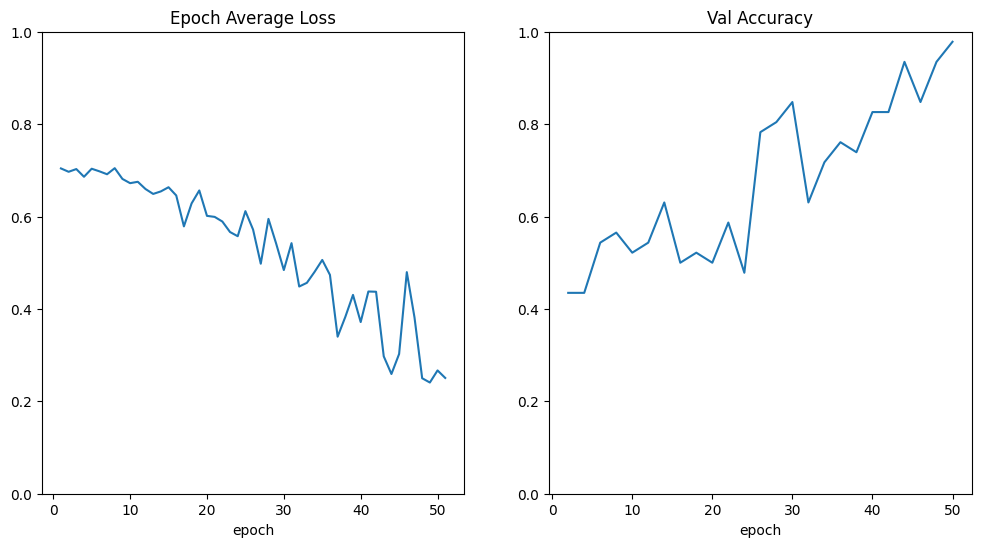

In [26]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.subplot(1, 2, 2)
plt.title("Val Accuracy")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.show()